In [27]:
# basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# sklearn
# preprocessing, model selection and metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# visualize importances
import shap

pd.set_option('max_columns', None)
plt.style.use('ggplot')

In [28]:
from datetime import date
import gc

In [29]:
my_data = '../ikeda/data/'
fat_ljs_atual = pd.read_csv(my_data + 'faturamento_lojas_atuais.csv')
cen_exp = pd.read_csv(my_data + 'cenarios_expansao.csv')
ljs_atual = pd.read_csv(my_data + 'lojas_atuais.csv')

In [30]:
ljs_atual.cod_loja.nunique()

3130

In [31]:
cen_exp.head()

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,10,2933307005008,2933307,FEATURE_01_VALUE_08,FEATURE_02_VALUE_02,False,50.00,FEATURE_05_VALUE_03,6,0.134654,0.131481,116.194058,2.913498,FEATURE_11_VALUE_01,FEATURE_12_VALUE_01,100.0,93.4,100.0,100.0,71.7,88.8
1,13,2916401003002,2916401,FEATURE_01_VALUE_10,FEATURE_02_VALUE_04,False,41.00,FEATURE_05_VALUE_03,4,0.116662,0.114995,26.345742,1.312612,NaN,NaN,84.3,77.5,100.0,100.0,63.5,78.8
2,16,2928703003003,2928703,NaN,FEATURE_02_VALUE_04,False,42.12,FEATURE_05_VALUE_05,2,0.104162,0.087807,35.362788,1.969512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,2906006003001,2906006,NaN,FEATURE_02_VALUE_04,False,30.00,FEATURE_05_VALUE_03,6,0.132954,0.131330,9.862757,1.383681,NaN,NaN,85.0,76.9,100.0,100.0,100.0,92.9
4,28,3550308005058,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,44.31,FEATURE_05_VALUE_03,8,0.190102,0.179140,5593.905463,2.815883,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df = fat_ljs_atual.merge(ljs_atual, on='cod_loja', how='inner')
df["datetime"] = pd.to_datetime(df.ano*100 + df.mes, format='%Y%m')
df.drop(["ano", "mes"], axis=1, inplace=True)

In [33]:
s = set(fat_ljs_atual.columns) - set(['ano', 'mes'])
s.add('datetime')
s

{'categoria', 'cod_loja', 'datetime', 'qtde', 'receita'}

In [34]:
fat_mes_df = df[list(s)].groupby(["cod_loja", "datetime"] , as_index=False).sum()

In [35]:
df_fat_mes = fat_mes_df.merge(ljs_atual, on="cod_loja", how='inner')

In [36]:
lojas_sem_24_meses = []
for i in df_fat_mes["cod_loja"].unique():
    if df_fat_mes[df_fat_mes["cod_loja"] == i].shape[0] != 24:
        lojas_sem_24_meses.append(i)

train_df = df_fat_mes[~df_fat_mes["cod_loja"].isin(lojas_sem_24_meses).values]

# Imputing

In [37]:
print('## FEATURE 1 ##')
print(train_df.feature_01.describe())
print('## FEATURE 11 ##')
print(train_df.feature_11.describe())
print('## FEATURE 12 ##')
print(train_df.feature_12.describe())
print('## FEATURE 13 ##')
print(train_df.feature_13.describe())
print('## FEATURE 14 ##')
print(train_df.feature_14.describe())
print('## FEATURE 15 ##')
print(train_df.feature_15.describe())
print('## FEATURE 16 ##')
print(train_df.feature_16.describe())
print('## FEATURE 17 ##')
print(train_df.feature_17.describe())
print('## FEATURE 18 ##')
print(train_df.feature_18.describe())

## FEATURE 1 ##
count                   25440
unique                      3
top       FEATURE_01_VALUE_10
freq                    14808
Name: feature_01, dtype: object
## FEATURE 11 ##
count                    5760
unique                      7
top       FEATURE_11_VALUE_02
freq                     2304
Name: feature_11, dtype: object
## FEATURE 12 ##
count                    5760
unique                      2
top       FEATURE_12_VALUE_01
freq                     3600
Name: feature_12, dtype: object
## FEATURE 13 ##
count    20736.000000
mean        94.813310
std          8.602639
min         44.100000
25%         92.200000
50%        100.000000
75%        100.000000
max        100.000000
Name: feature_13, dtype: float64
## FEATURE 14 ##
count    20736.000000
mean        83.698727
std         13.575930
min          0.000000
25%         79.675000
50%         86.900000
75%         91.900000
max        100.000000
Name: feature_14, dtype: float64
## FEATURE 15 ##
count    20736.000000
mea

In [38]:
has_na_cols = list()
for col in train_df.columns:
    if train_df[col].isnull().values.any():
        has_na_cols.append(col)
has_na_cols

['feature_01',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18']

In [39]:
for na_col in has_na_cols:
    if train_df[na_col].dtype == object:
        print(train_df[na_col].mode()[0])
        train_df[na_col].fillna(train_df[na_col].mode()[0], inplace=True)
    else:
        train_df[na_col].fillna(train_df[na_col].median(), inplace=True)

FEATURE_01_VALUE_10
FEATURE_11_VALUE_02
FEATURE_12_VALUE_01



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
cols = train_df.columns

In [41]:
model_df = train_df[cols]
model_df["month"] = model_df["datetime"].dt.month
model_df["quarter"] = model_df["datetime"].dt.quarter
model_df["year"] = model_df["datetime"].dt.year

## Adicionando coluna para proporção percentual na microrregião

In [42]:
micro_df = pd.read_csv(my_data + "dados_ppib_micro.csv")
model_df = model_df.merge(micro_df, how='left', left_on='cod_municipio', right_on='cod_mun')
model_df.drop(columns=['cod_mun', 'nome_mun'], inplace=True)

In [43]:
model_df['pct_micro'].fillna(model_df['pct_micro'].median(), inplace=True)

## Adicionando proporção de jovens e jovens adultos

In [44]:
pop_id_df = pd.read_csv(my_data + "dados_popidade.csv")

In [45]:
jovem_df = pop_id_df[pop_id_df.Idade == '0 a 4 anos'][['cod_municipio','Total']].rename(columns={'Total':'t1'})
k2_df = pop_id_df[pop_id_df.Idade == '5 a 9 anos'][['cod_municipio','Total']].rename(columns={'Total':'t2'})
k3_df = pop_id_df[pop_id_df.Idade == '10 a 14 anos'][['cod_municipio','Total']].rename(columns={'Total':'t3'})
k4_df = pop_id_df[pop_id_df.Idade == '15 a 17 anos'][['cod_municipio','Total']].rename(columns={'Total':'t4'})
jovem_df = jovem_df.merge(k2_df, on='cod_municipio')
jovem_df = jovem_df.merge(k3_df, on='cod_municipio')
jovem_df = jovem_df.merge(k4_df, on='cod_municipio')
jovem_df['jov_total'] = jovem_df.t1 + jovem_df.t2 + jovem_df.t3 + jovem_df.t4
jovem_df.drop(columns=['t1','t2','t3','t4'], inplace=True)

In [46]:
jv_ad_df = pop_id_df[pop_id_df.Idade == '18 ou 19 anos'][['cod_municipio','Total']].rename(columns={'Total':'t1'})
k2_df = pop_id_df[pop_id_df.Idade == '20 a 24 anos'][['cod_municipio','Total']].rename(columns={'Total':'t2'})
k3_df = pop_id_df[pop_id_df.Idade == '25 a 29 anos'][['cod_municipio','Total']].rename(columns={'Total':'t3'})
jv_ad_df = jv_ad_df.merge(k2_df, on='cod_municipio')
jv_ad_df = jv_ad_df.merge(k3_df, on='cod_municipio')
jv_ad_df['jv_ad_total'] = jv_ad_df.t1 + jv_ad_df.t2 + jv_ad_df.t3
jv_ad_df.drop(columns=['t1','t2','t3'], inplace=True)
del(k2_df)
del(k3_df)
del(k4_df)

In [47]:
model_df = model_df.merge(jovem_df, on='cod_municipio', how='left')
model_df = model_df.merge(jv_ad_df, on='cod_municipio', how='left')
pop_df = pd.read_csv(my_data + "dados_pop.csv")
model_df = model_df.merge(pop_df, how='left', on='cod_municipio')
model_df['prop_jov'] = model_df.jov_total / model_df.Total
model_df['prop_jadulto'] = model_df.jv_ad_total / model_df.Total
model_df.drop(columns=['jov_total', 'jv_ad_total', 'Total', 'Homens', 'Mulheres'], inplace=True)
model_df['prop_jov'].fillna(model_df['prop_jov'].median(), inplace=True)
model_df['prop_jadulto'].fillna(model_df['prop_jadulto'].median(), inplace=True)

In [48]:
str_cols = list()
for col in model_df.columns.values.tolist():
    if model_df[col].dtype == object:
        str_cols.append(col)

In [49]:
str_cols.append('datetime') 
str_cols.append('receita')
str_cols.append('qtde')

In [50]:
str_cols

['feature_01',
 'feature_02',
 'feature_05',
 'feature_11',
 'feature_12',
 'Município',
 'Idade',
 'Condição no domicílio e o compartilhamento da responsabilidade pelo domicílio',
 'datetime',
 'receita',
 'qtde']

In [51]:
train = model_df[~model_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]
test = model_df[model_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]

X_train = train.drop(str_cols, axis=1)
y_train = train["receita"]

X_test = test.drop(str_cols, axis=1)
y_test = test["receita"]

In [52]:
X_train.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_03', 'feature_04',
       'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'month', 'quarter', 'year', 'pct_micro', 'prop_jov',
       'prop_jadulto'],
      dtype='object')

# Train

In [53]:
errors = list()

In [54]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)

rf.fit(X_train.values, y_train.values)
y_pred = rf.predict(X_test)
m = np.sqrt(mean_squared_error(y_test, y_pred))
errors.append(m)
m

34549.05181536012

In [36]:
lojas = ljs_atual.cod_loja.unique()

In [37]:
len(lojas)

3130

In [41]:
X

,cod_loja,cod_ap,cod_municipio,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,month,quarter,year,pct_micro,feature_01_FEATURE_01_VALUE_03,feature_01_FEATURE_01_VALUE_08,feature_01_FEATURE_01_VALUE_10,feature_02_FEATURE_02_VALUE_02,feature_02_FEATURE_02_VALUE_03,feature_02_FEATURE_02_VALUE_04,feature_02_FEATURE_02_VALUE_06,feature_05_FEATURE_05_VALUE_01,feature_05_FEATURE_05_VALUE_02,feature_05_FEATURE_05_VALUE_03,feature_05_FEATURE_05_VALUE_04,feature_05_FEATURE_05_VALUE_05,feature_05_FEATURE_05_VALUE_06,feature_05_FEATURE_05_VALUE_07,feature_05_FEATURE_05_VALUE_08,feature_11_FEATURE_11_VALUE_01,feature_11_FEATURE_11_VALUE_02,feature_11_FEATURE_11_VALUE_03,feature_11_FEATURE_11_VALUE_04,feature_11_FEATURE_11_VALUE_05,feature_11_FEATURE_11_VALUE_06,feature_11_FEATURE_11_VALUE_07,feature_12_FEATURE_12_VALUE_01,feature_12_FEATURE_12_VALUE_02,prop_jov,prop_jadulto
68373,3520,2611606005018,2611606,False,36.0,2,0.124266,0.072713,889.577909,5.256053,100.0,86.9,100.0,100.0,91.05,90.5,10,4,2017,64.49,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.258325,0.21546
68374,3520,2611606005018,2611606,False,36.0,2,0.124266,0.072713,889.577909,5.256053,100.0,86.9,100.0,100.0,91.05,90.5,11,4,2017,64.49,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.258325,0.21546
68375,3520,2611606005018,2611606,False,36.0,2,0.124266,0.072713,889.577909,5.256053,100.0,86.9,100.0,100.0,91.05,90.5,12,4,2017,64.49,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.258325,0.21546


In [105]:
lojas_int = [2507, 3490, 1912, 3635, 2795, 2549, 2076, 297]
lint_df = ljs_atual[ljs_atual['cod_loja'] == lojas_int[0]]
lint_df

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
2125,2507,2303709005010,2303709,NaN,FEATURE_02_VALUE_03,False,31.0,FEATURE_05_VALUE_03,16,0.15355,0.141161,129.320673,0.84762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


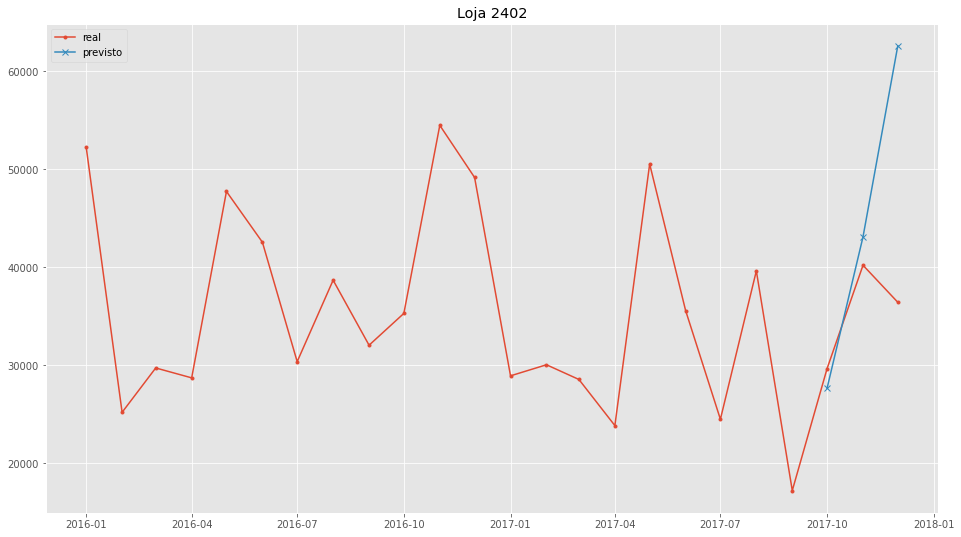

In [121]:
cod_loja = np.random.choice(model_df["cod_loja"].unique())
t = model_df[model_df["cod_loja"] == cod_loja]
t["datetime"] = pd.to_datetime(t.year*100 + t.month, format='%Y%m')

X = X_test[X_test["cod_loja"] == cod_loja]
X["datetime"] = pd.to_datetime(X.year*100 + X.month, format='%Y%m')
y_pred = rf.predict(X[X_train.columns])

plt.figure(figsize=(16,9))
plt.title("Loja {}".format(cod_loja))
plt.plot(t["datetime"], t["receita"], label="real", marker=".")
plt.plot(X["datetime"], y_pred, label="previsto", marker="x")
plt.legend()
plt.show()

In [26]:
del model_df, train, test, X_train, X_test, y_train, y_test, train_df
gc.collect()

181

# Submission

In [45]:
# copy df_fat_mes
train_df = df_fat_mes

print(train_df.cod_loja.nunique())

# get cols with nans
has_na_cols = list()
for col in train_df.columns:
    if train_df[col].isnull().values.any():
        has_na_cols.append(col)
# input values
for na_col in has_na_cols:
    if train_df[na_col].dtype == object:
        print(train_df[na_col].mode()[0])
        train_df[na_col].fillna(train_df[na_col].mode()[0], inplace=True)
    else:
        train_df[na_col].fillna(train_df[na_col].median(), inplace=True)

# get cols for model
cols = train_df.columns
model_df = train_df[cols]
model_df["month"] = model_df["datetime"].dt.month
model_df["quarter"] = model_df["datetime"].dt.quarter
model_df["year"] = model_df["datetime"].dt.year

# get str and unused cols
str_cols = list()
for col in model_df.columns.values.tolist():
    if model_df[col].dtype == object:
        str_cols.append(col)
str_cols.append('datetime') 
str_cols.append('receita')
str_cols.append('qtde')

# train test split
train = model_df[~model_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]
test = model_df[model_df["datetime"].isin([date(2017,10,1), date(2017,11,1), date(2017,12,1)])]

print(model_df.cod_loja.nunique())

# X_train = train.drop(str_cols, axis=1)
# y_train = train["receita"]
# X_test = test.drop(str_cols, axis=1)
# y_test = test["receita"]

# predict
train_cols = X_train.columns.values.tolist()
preds = []
i = 0
for loja in lojas:
    Xloja = model_df[model_df.cod_loja == loja][:1]
    i += 1
    Xloja = Xloja[train_cols]
    Xloja = pd.DataFrame(Xloja.values.tolist()*3, columns=Xloja.columns)
    Xloja.month = pd.Series([1,2,3]).values
    Xloja.quarter = pd.Series([1,1,1]).values
    Xloja.year = pd.Series([2018,2018,2018]).values
    yhat = rf.predict(Xloja)
    preds.append((loja, yhat))
print(i)

3130
3130
3130


In [46]:
submission = pd.DataFrame({'cod_loja': [i[0] for i in preds], 'faturamento': [np.sum(i[1]) for i in preds]})
submission.cod_loja.nunique()

3130

In [47]:
submission.to_csv('/home/tuts/repos/others/usp-vs-ufmg/tutss/desafio_1.csv', index=False, sep=';')